In [29]:
import keras
from keras.layers import Concatenate, Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from ipywidgets import interact, IntSlider
import keras.callbacks  # Add this import statement for callbacks

In [2]:
train_path = '/kaggle/input/ebram-data/new_data/train'
val_path = '/kaggle/input/ebram-data/new_data/validation'

In [3]:
# Image size and batch size
img_size = (128, 128)
batch_size = 16

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# No Data Augmentation for Validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=False  # No need to shuffle validation data
)

Found 135 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


In [4]:
print(train_generator.samples)
print(val_generator.samples)

135
35


In [5]:
# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [6]:
# Define input shape
input_shape = (*img_size, 3)  # 3 channels for RGB images

latent_dim = 100
num_channels = 3
original_dim = 128 * 128 * 3
num_classes = 2  # Assuming 2 classes in your dataset


In [7]:
# Encoder with Conditional Input
conditional_inputs = Input(shape=(num_classes,), name='conditional_input')
inputs = Input(shape=input_shape, name='encoder_input')

x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Concatenate()([x, conditional_inputs])


In [8]:
z_mean = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])


In [9]:
encoder = Model([inputs, conditional_inputs], [z_mean, z_log_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 262144)               0         ['conv2d_1[0][0]']            
                                                                                            

In [10]:
# Decoder with Conditional Input
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_cond_inputs = Concatenate()([latent_inputs, conditional_inputs])
x = Dense(128, activation='relu')(decoder_cond_inputs)
x = Dense(256, activation='relu')(x)
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(x)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
outputs = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model([latent_inputs, conditional_inputs], outputs, name='decoder')
print(decoder.summary())

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 z_sampling (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 conditional_input (InputLa  [(None, 2)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 concatenate_1 (Concatenate  (None, 102)                  0         ['z_sampling[0][0]',          
 )                                                                   'conditional_input[0][0]']   
                                                                                            

In [11]:
# CVAE Model
vae_outputs = decoder([encoder([inputs, conditional_inputs])[2], conditional_inputs])
vae = Model([inputs, conditional_inputs], vae_outputs, name='vae')
print(vae.summary())

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conditional_input (InputLa  [(None, 2)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 encoder (Functional)        [(None, 100),                6718760   ['encoder_input[0][0]',       
                              (None, 100),                8          'conditional_input[0][0]']   
                              (None, 100)]                                                      

In [12]:
# Reshape the input and outputs for loss calculation
input_flatten = K.flatten(inputs)
vae_outputs_flatten = K.flatten(vae_outputs)

reconstruction_loss = keras.losses.binary_crossentropy(input_flatten, vae_outputs_flatten)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

In [13]:
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)

vae.compile(optimizer=Adam(lr=0.0001))

In [14]:
def custom_generator(generator):
    for batch in generator:
        images = batch[0]  # Assuming images are in the first index of the batch
        labels = batch[1]  # Assuming conditional inputs are in the second index of the batch
        yield [images, labels], images  # Providing both images and conditional inputs as inputs and images as outputs



In [15]:
# Train the CVAE model using the custom generator
history = vae.fit(
    custom_generator(train_generator),
    epochs=300,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=custom_generator(val_generator),
    validation_steps=val_generator.samples // batch_size,
    verbose=1
)

Epoch 1/300
8/8 [==============================] - 17s 359ms/step - loss: 33889.5469 - val_loss: 33510.1562
Epoch 2/300
8/8 [==============================] - 2s 194ms/step - loss: 33472.7383 - val_loss: 33279.4844
Epoch 3/300
8/8 [==============================] - 2s 251ms/step - loss: 33283.1328 - val_loss: 33379.1094
Epoch 4/300
8/8 [==============================] - 2s 232ms/step - loss: 33169.2344 - val_loss: 32980.3672
Epoch 5/300
8/8 [==============================] - 2s 205ms/step - loss: 33059.3906 - val_loss: 32847.0859
Epoch 6/300
8/8 [==============================] - 2s 259ms/step - loss: 32747.5859 - val_loss: 32738.0547
Epoch 7/300
8/8 [==============================] - 1s 194ms/step - loss: 32790.5586 - val_loss: 32629.9512
Epoch 8/300
8/8 [==============================] - 2s 235ms/step - loss: 32572.4434 - val_loss: 32527.2441
Epoch 9/300
8/8 [==============================] - 2s 232ms/step - loss: 32692.9629 - val_loss: 32403.4824
Epoch 10/300
8/8 [==================

1/1 [==============================] - 0s 20ms/step


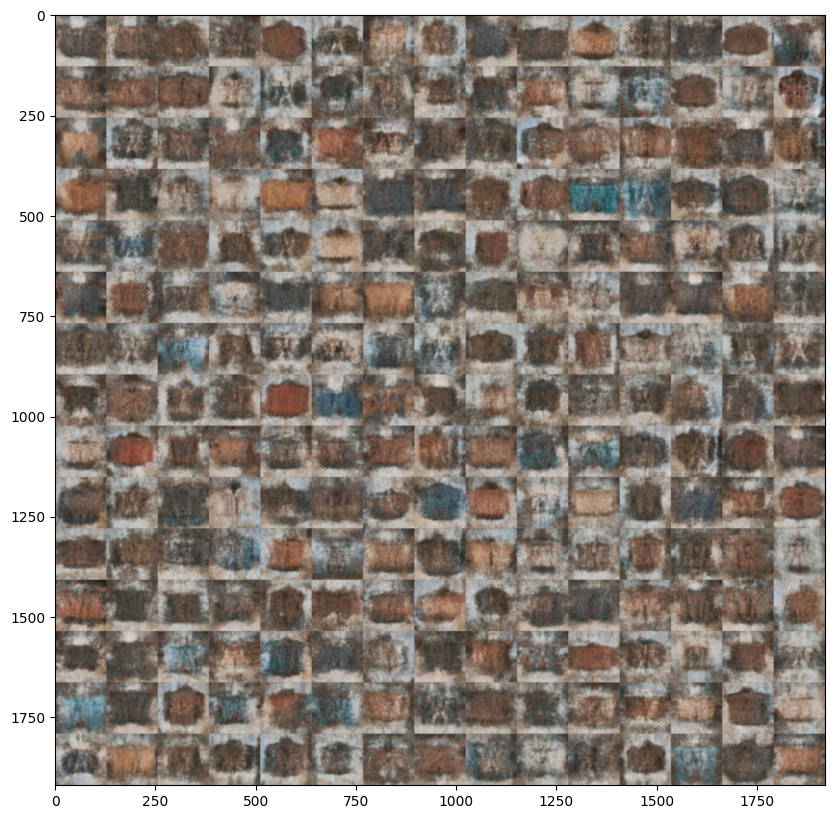

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_grid(decoder, img_size, latent_dim, num_channels, num_classes, class_index=0, n=15):
    # Set the size of the grid
    figure = np.zeros((img_size[0] * n, img_size[1] * n, num_channels))

    # Create a grid of latent variables
    grid_x = np.linspace(-5, 5, n)
    grid_y = np.linspace(-5, 5, n)[::-1]

    # Generate images for each point in the grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.normal(size=(1, latent_dim))  # latent_dim is 100
            conditional_input = np.zeros((1, num_classes))
            conditional_input[:, class_index] = 1  # Set the specific class index to 1
            
            # Generate image using decoder model
            x_decoded = decoder.predict([z_sample, conditional_input])
            digit = x_decoded[0].reshape(img_size[0], img_size[1], num_channels)
            
            figure[i * img_size[0]: (i + 1) * img_size[0], j * img_size[1]: (j + 1) * img_size[1]] = digit

    # Reshape for visualization
    fig_shape = np.shape(figure)
    figure = figure.reshape((fig_shape[0], fig_shape[1], num_channels))

    # Plot the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gnuplot2')
    plt.show()

# Example usage:
# Assuming 'decoder' is your decoder model and other parameters are defined
generate_image_grid(decoder, img_size=(128, 128), latent_dim=100, num_channels=3, num_classes=2, class_index=0, n=15)


In [38]:
def generate_images(num_images=5, max_images=30, class_label=0):
    img_size = (128, 128)  # Define your image size here
    latent_dim = 100  # Define your latent dimension here
    num_channels = 3  # Define your number of channels here
    num_classes = 2  # Define your number of classes here
    
    generate_image_grid(decoder, img_size, latent_dim, num_channels, num_classes, class_label, n=num_images)


In [39]:
# Interact function with sliders for num_images, max_images, and class_label
interact(
    generate_images,
    num_images=IntSlider(min=1, max=30, step=1, value=5),
    max_images=IntSlider(min=5, max=100, step=1, value=30),
    class_label=IntSlider(min=0, max=1, step=1, value=0, description='Class Label')
)

interactive(children=(IntSlider(value=5, description='num_images', max=30, min=1), IntSlider(value=30, descrip…

<function __main__.generate_images(num_images=5, max_images=30, class_label=0)>